# fuser

参考: [zju3dv/pvnet-rendering](https://github.com/zju3dv/pvnet-rendering)

In [1]:
import os
import sys
sys.path.append('.')
sys.path.append('..')
sys.path.append('../../')
import time
from concurrent.futures import ProcessPoolExecutor
from glob import glob

import cv2
import numpy as np

from src.config.config import cfg

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

## Setup

In [3]:
from src.utils.utils import MakeDir

tmp_dir = MakeDir(cfg.TEMP_DIR, newly=True)
cache_dir= tmp_dir
output_dir = tmp_dir
idx = 1
pvnet_linemod_dir = cfg.PVNET_LINEMOD_DIR
linemod_dir = cfg.LINEMOD_DIR
obj_name = 'ape'
background_dir = cfg.TEST_IMG_ORG_DIR
fuse_num = 5
worker_num=2

## __collect_train_val_test_info Test

In [4]:
def __collect_train_val_test_info(pvnet_linemod_dir: str,
                                                                      obj_name: str) -> list:
    """
    PVNet LineMod データセットのカテゴリごとに保存されている training.txt と test.txt ファイルから訓練とテストとして使用するファイル名のリストを返す関数

    Args:
        pvnet_linemod_dir(str): PVNet_LineMod ディレクトリパス
        obj_name(str): LineMod データセットに含まれるオブジェクト名

    Return:
        test_fns(list): テストデータとして使用される画像のファイル名
        train_fns(list): 訓練データとして使用される画像のフィアル名
    """
    with open(os.path.join(pvnet_linemod_dir, obj_name, 'test.txt'), 'r') as f:
        test_fns = [line.strip().split('/')[-1] for line in f.readlines()]

    with open(os.path.join(pvnet_linemod_dir, obj_name, 'train.txt'), 'r') as f:
        train_fns=[line.strip().split('/')[-1] for line in f.readlines()]

    return test_fns, train_fns

In [5]:
fns = __collect_train_val_test_info(pvnet_linemod_dir=pvnet_linemod_dir,
                                                                        obj_name=obj_name)

print('fns =')
print(fns[0][0])

fns =
000000.jpg


## ModelAligner をロード

In [6]:
from Blender.render_base_utils import ModelAligner

## PoseTransformer をロード

In [7]:
from Blender.render_base_utils import PoseTransformer

In [8]:
from src.datasets.LineMod.LineModDB import read_pose
from src.utils.base_utils import read_mask_np, read_rgb_np, read_pickle, save_pickle

## _collect_linemod_set_info Test

In [9]:
from fuse import _collect_linemod_set_info

In [10]:
data_base = _collect_linemod_set_info(linemod_dir,
                                                                                   pvnet_linemod_dir ,
                                                                                   obj_name,
                                                                                   cache_dir)
print(u'Create data_base！')
print(data_base)

{'rgb_pth': '/media/miki/DATA/My_programing/python/AI/Analysis/data/PVNet_linemod/ape/JPEGImages/000914.jpg', 'dpt_pth': '/media/miki/DATA/My_programing/python/AI/Analysis/data/PVNet_linemod/ape/mask/0914.png', 'RT': array([[-0.0536252 ,  0.975377  , -0.213925  ,  0.00464225],
       [ 0.962547  , -0.00652554, -0.271037  , -0.07789672],
       [-0.265759  , -0.220448  , -0.938496  ,  0.6899649 ]],
      dtype=float32)}, {'rgb_pth': '/media/miki/DATA/My_programing/python/AI/Analysis/data/PVNet_linemod/ape/JPEGImages/000924.jpg', 'dpt_pth': '/media/miki/DATA/My_programing/python/AI/Analysis/data/PVNet_linemod/ape/mask/0924.png', 'RT': array([[ 0.158203  ,  0.987404  ,  0.00231161,  0.02194063],
       [ 0.939107  , -0.149741  , -0.309283  , -0.09517974],
       [-0.305042  ,  0.0511006 , -0.950967  ,  0.6669531 ]],
      dtype=float32)}, {'rgb_pth': '/media/miki/DATA/My_programing/python/AI/Analysis/data/PVNet_linemod/ape/JPEGImages/000927.jpg', 'dpt_pth': '/media/miki/DATA/My_programing

## randomly_read_background Test

In [11]:
from render_base_utils import randomly_read_background

img type: <class 'numpy.ndarray'>
size: (683, 1024, 3)


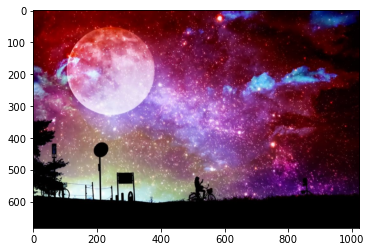

In [12]:
_, img = randomly_read_background(bg_imgs_dir=background_dir,
                                                                              cache_dir=cache_dir)

print('img type: {}'.format(type(img)))
print('size: {}'.format(img.shape))
fig = plt.figure()
plt.imshow(img)
plt.show()

## __randomly_sample_foreground Test

In [13]:
def __randomly_sample_foreground(image_db: dict, pvnet_linemod_dir: str):
    """
    画像合成の際に背景上に配置するオブジェクトを `_collect_linemod_set_info` で保存した下記の情報をもとに読み出し，rgb画像，mask画像，対応するオブジェクトの姿勢を返す関数

    image_db:
        * rgb_pth: JPEG 画像のパス
        * dpt_pth: JPEG 画像に対応する Mask 画像のパス
        * RT: 対象オブジェクトの姿勢情報

    Aegs:
        image_db(dict): pvnet_linemod の rgb_pth, dpt_pth, と orig_pose_to_blender_pose によって変換された 同次変換行列が格納された辞書．{'rgb_pth': '/media/miki/DATA/My_programing/python/AI/Analysis/data/PVNet_linemod/ape/JPEGImages/000914.jpg', 'dpt_pth': '/media/miki/DATA/My_programing/python/AI/Analysis/data/PVNet_linemod/ape/mask/0914.png', 'RT': array([[-0.0536252 ,  0.975377  , -0.213925  ,  0.00464225],
       [ 0.962547  , -0.00652554, -0.271037  , -0.07789672],
       [-0.265759  , -0.220448  , -0.938496  ,  0.6899649 ]],
      dtype=float32)}, 
        pvnet_linemod_dir (str): PVNet_LineMod データセットのディレクトリパス

    Return:
        rgb(np.ndarray): rgb画像の ndarray 配列 [max = 255, min = 0]
        mask(np.ndarray): mask画像の ndarray 配列 [max = 1, min = 0]
        begin(list):
        pose(np.ndarray): オブジェクトの姿勢 [RT| 3x4行列]
    """
    idx = np.random.randint(0, len(image_db))
    rgb_pth = os.path.join(pvnet_linemod_dir,image_db[idx]['rgb_pth'])
    dpt_pth = os.path.join(pvnet_linemod_dir,image_db[idx]['dpt_pth'])
    rgb = read_rgb_np(rgb_pth)
    mask = read_mask_np(dpt_pth)
    mask = np.sum(mask, 2) > 0
    mask = np.asarray(mask, np.int32)

    hs, ws = np.nonzero(mask)
    hmin, hmax = np.min(hs), np.max(hs)
    wmin, wmax  = np.min(ws), np.max(ws)

    mask = mask[hmin:hmax, wmin:wmax]
    rgb = rgb[hmin:hmax, wmin:wmax]

    rgb *= mask.astype(np.uint8)[:, :, None]
    begin = [hmin, wmin]
    pose = image_db[idx]['RT']

    return rgb, mask, begin, pose

In [14]:
pkl_pth = os.path.join(tmp_dir, 'ape_info.pkl')
img_db = read_pickle(pkl_path=pkl_pth)

rgb, mask, begin, pose = __randomly_sample_foreground(image_db=img_db, pvnet_linemod_dir=pvnet_linemod_dir)

rgb type = <class 'numpy.ndarray'>
rgb max = 217, min = 0
rgb shape = (66, 49, 3)


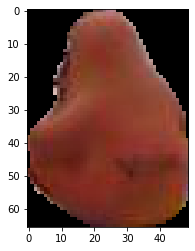

In [15]:
print('rgb type =', type(rgb))
print('rgb max = {}, min = {}'.format(rgb.max(), rgb.min()))
print('rgb shape =', rgb.shape)

fig = plt.figure()
plt.imshow(rgb)
plt.show()

mask type = <class 'numpy.ndarray'>
mask max = 1, min = 0
mask shape = (66, 49)


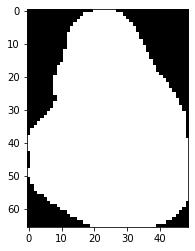

In [16]:
print('mask type =', type(mask))
print('mask max = {}, min = {}'.format(mask.max(), mask.min()))
print('mask shape =', mask.shape)

fig = plt.figure()
plt.imshow(mask, cmap='gray')
plt.show()

In [17]:
print('begin type =', type(begin))
print(begin)

begin type = <class 'list'>
[235, 328]


In [18]:
print('pose type =', type(pose))
print('pose max = {}, min = {}'.format(pose.max(), pose.min()))
print('pose shape =', pose.shape)

pose type = <class 'numpy.ndarray'>
pose max = 0.9443089962005615, min = -0.9713900089263916
pose shape = (3, 4)


## _fuse_regions Test

In [19]:
def _fuse_regions(rgbs: list,
                                      masks: list,
                                      begins: list,
                                      background: np.ndarray,
                                      th: int,
                                      tw: int):
    """
    RGB背景画像とそのマスク画像を (tw, th) にリサイズし，その上にオブジェクトのRGB画像とそのマスク画像を合成する関数．返り値は，合成されたRGB画像とそのマスク画像と合成されたオブジェクトの位置

    Args:
        rgbs(list): 合成するオブジェクトの ndarray が保存されたリスト
        masks(list): 合成するオブジェクトのマスク画像の ndarray が保存されたリスト
        begins(list): 
        background(np.ndarray): 背景の ndarray
        th(int): 背景画像のリサイズ後の高さ
        tw(int): 背景画像のリサイズ後の幅
    
    Returns:
        fuse_img(np.ndarray): 合成後の画像 [max=255, min=0]
        fuse_mask(np.ndarray): 合成後のマスク画像 [max=1 min=0]
        begins(list)
    """
    fuse_order = np.arange(len(rgbs))
    np.random.shuffle(fuse_order)
    fuse_img = background
    fuse_img = cv2.resize(fuse_img, (tw,th), interpolation = cv2.INTER_LINEAR) # Bilinearによる内挿法を用いてリサイズ
    fuse_mask = np.zeros([fuse_img.shape[0], fuse_img.shape[1]], np.int32)
    
    for idx in fuse_order:
        rh,rw = masks[idx].shape
        # 背景画像より外にオブジェクトが配置されないように調整
        bh = np.random.randint(0, fuse_img.shape[0]-rh)
        bw = np.random.randint(0, fuse_img.shape[1]-rw)

        silhouette = masks[idx] > 0
        out_silhouette = np.logical_not(silhouette)
        fuse_mask[bh:bh+rh,bw:bw+rw] *= out_silhouette.astype(fuse_mask.dtype)
        fuse_mask[bh:bh+rh,bw:bw+rw] += masks[idx]

        fuse_img[bh:bh+rh,bw:bw+rw] *= out_silhouette.astype(fuse_img.dtype)[:, :, None]
        fuse_img[bh:bh+rh,bw:bw+rw] += rgbs[idx]

        begins[idx][0] =- begins[idx][0] + bh
        begins[idx][1] =- begins[idx][1] + bw

    return fuse_img, fuse_mask, begins

In [20]:
rgbs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
fuse_order=np.arange(len(rgbs))
print('fuse_order =', fuse_order)
np.random.shuffle(fuse_order)
print('random =', fuse_order)

th, tw = 480, 640
fuse_img = randomly_read_background(background_dir, cache_dir)
fuse_img = cv2.resize(fuse_img, (tw,th), interpolation = cv2.INTER_LINEAR) # Bilinearによる内挿法を用いてリサイズ
fuse_mask = np.zeros([fuse_img.shape[0], fuse_img.shape[1]], np.int32)

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(fuse_img)
ax1.set_title('fuse image')

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(fuse_mask)
ax2.set_title('fuse mask')
plt.tight_layout()
plt.show()

fuse_order = [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
random = [ 1  7 10  0 12  4 11  6  3  8  2  5  9]


ValueError: low >= high

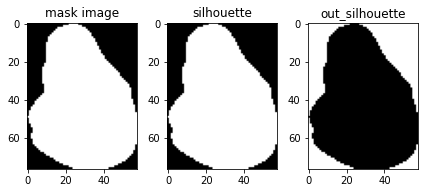

In [35]:
rh,rw = mask.shape
# 背景画像より外にオブジェクトが配置されないように調整
bh = np.random.randint(0, fuse_img.shape[0] - rh)
bw = np.random.randint(0, fuse_img.shape[1] - rw)

silhouette = mask > 0
out_silhouette = np.logical_not(silhouette)

fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(mask, cmap='gray')
ax1.set_title('mask image')

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(silhouette, cmap='gray')
ax2.set_title('silhouette')

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(out_silhouette, cmap='gray')
ax3.set_title('out_silhouette')

plt.tight_layout()
plt.show()

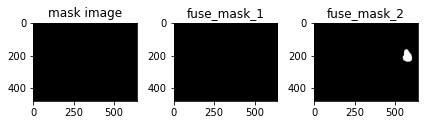

In [36]:
fuse_mask_1 = fuse_mask.copy()

fuse_mask_1[bh:bh+rh,bw:bw+rw] *= out_silhouette.astype(fuse_mask.dtype)
fuse_mask_2 = fuse_mask_1.copy()
fuse_mask_2[bh:bh+rh,bw:bw+rw] += mask

fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(fuse_mask, cmap='gray')
ax1.set_title('mask image')

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(fuse_mask_1, cmap='gray')
ax2.set_title('fuse_mask_1')

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(fuse_mask_2, cmap='gray')
ax3.set_title('fuse_mask_2')

plt.tight_layout()
plt.show()

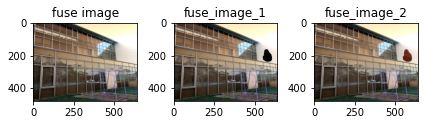

In [37]:
fuse_img_1 = fuse_img.copy()
fuse_img_1[bh:bh+rh,bw:bw+rw] *= out_silhouette.astype(fuse_img.dtype)[:,:,None]
fuse_img_2 = fuse_img_1.copy()
fuse_img_2[bh:bh+rh,bw:bw+rw] += rgb

fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(fuse_img)
ax1.set_title('fuse image')

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(fuse_img_1)
ax2.set_title('fuse_image_1')

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(fuse_img_2)
ax3.set_title('fuse_image_2')

plt.tight_layout()
plt.show()

In [38]:
def _save_fuse_data(output_dir: str,
                                          idx: int,
                                          fuse_img: np.ndarray,
                                          fuse_mask: np.ndarray,
                                          fuse_begins,
                                          fuse_poses: list):
    """
    合成したデータを保存する関数

    Args:
        output_dir(str): データを保存するディレクトリのパス
        idx(int): 作成したデータの番号
        fuse_img(np.ndarray): 合成された画像の ndarray
        fuse_mask(np.ndarray): 合成された画像のマスク画像の ndarray
        fuse_begins()
        fuse_poses(list): 合成された画像に使用されているオブジェクトの姿勢 [RT| 3x4行列] のリスト
    """
    os.makedirs(output_dir, exist_ok=True)
    cv2.imwrite(os.path.join(output_dir,
                                                        '{}_rgb.jpg'.format(idx)),
                                                        fuse_img)
    fuse_mask=fuse_mask.astype(np.uint8)
    cv2.imwrite(os.path.join(output_dir,
                                                        '{}_mask.png'.format(idx)),
                                                        fuse_mask)
    save_pickle([np.asarray(fuse_begins,np.int32), 
                                np.asarray(fuse_poses,np.float32)],
                              os.path.join(output_dir,'{}_info.pkl'.format(idx)))

## _prepare_dataset_single Test

In [39]:
def _prepare_dataset_single(output_dir: str,
                                                             idx: int,
                                                             pvnet_linemod_dir: str,
                                                             linemod_dir: str,
                                                             background_dir: str,
                                                             obj_names: list = cfg.linemod_obj_names,
                                                             cache_dir: str = './',
                                                             seed: int = 0):
    """
    オブジェクトの画像と別の背景画像を合成する関数

    Args:
        output_dir(str): 合成された画像を保存するディレクトリへのパス
        idx(int): 保存されるデータに振られる番号
        pvnet_linemod_dir (str): PVNet で作成された LINEMODデータセットが保存されているディレクトリパス
        linemod_dir (str): オリジナルのLINEMODデータセットが保存されているディレクトリパス
        background_dir (str): 背景画像として使用する画像の読み出し先のパス
        obj_names(list optional): 合成で使用するデータセットのクラス名．Defaults to cfg.linemod_obj_names.
        cache_dir (str, optional): オブジェクトごとに作成される `obj_name_info.pkl` データや合成画像の背景として使用される画像のパスを保存した `background_inf.pkl`の保存先のパス. Defaults to './'.
        seed (int, optional): オブジェクトを配置する際に使用する乱数のseed値. Defaults to 0.
    """
    time_begin = time.time()
    np.random.seed(seed)
    rgbs,masks,begins,poses = [], [], [], []
    image_dbs = {}
    for obj_id,obj_name in enumerate(obj_names):
        image_dbs[obj_id] = _collect_linemod_set_info(pvnet_linemod_dir,
                                                                                                             obj_name,
                                                                                                             linemod_dir,
                                                                                                             cache_dir)

    for obj_id, _ in enumerate(obj_names):
        rgb, mask, begin, pose = __randomly_sample_foreground(image_dbs[obj_id], pvnet_linemod_dir)
        mask *= obj_id+1
        rgbs.append(rgb)
        masks.append(mask)
        begins.append(begin)
        poses.append(pose)

    background = __randomly_read_background(background_dir, cache_dir)

    fuse_img, fuse_mask, fuse_begins = _fuse_regions(rgbs, masks, begins, background, 480, 640)

    _save_fuse_data(output_dir, idx, fuse_img, fuse_mask, fuse_begins, poses)
    print('{} cost {} s'.format(idx, time.time()-time_begin))

In [26]:
_prepare_dataset_single(output_dir=output_dir,
                                                      idx=idx,
                                                      pvnet_linemod_dir=pvnet_linemod_dir,
                                                      linemod_dir=linemod_dir,
                                                      background_dir=background_dir,
                                                      cache_dir=cache_dir)

begin generate database benchvise
success generate database benchvise len 183
begin generate database cam
success generate database cam len 181
begin generate database can
success generate database can len 180
begin generate database cat
success generate database cat len 177
begin generate database driller
success generate database driller len 179
begin generate database duck
success generate database duck len 189
begin generate database eggbox
success generate database eggbox len 188
begin generate database glue
success generate database glue len 184
begin generate database holepuncher
success generate database holepuncher len 186
begin generate database iron
success generate database iron len 173
begin generate database lamp
success generate database lamp len 185
begin generate database phone
success generate database phone len 184
1 cost 163.41809630393982 s


## prepare_dataset_parallel Test

In [27]:
def prepare_dataset_parallel(output_dir: str,
                                                              pvnet_linemod_dir: str,
                                                              linemod_dir: str,
                                                              background_dir: str,
                                                              obj_names: list = cfg.linemod_obj_names,
                                                              fuse_num: int=50,
                                                              cache_dir: str = './',
                                                              worker_num=8):
    """
    データセットの準備を並列して行う関数

    Args:
        output_dir (str): 
        pvnet_linemod_dir (str): PVNet で作成された LINEMODデータセットが保存されているディレクトリパス
        linemod_dir (str): オリジナルのLINEMODデータセットが保存されているディレクトリパス
        background_dir (str): 背景画像として使用する画像の読み出し先のパス
        obj_names(list optional): 合成で使用するデータセットのクラス名．Defaults to cfg.linemod_obj_names.
        fuse_num (int optional): 作成される合成画像枚数．Defaults to 50.
        cache_dir (str, optional): オブジェクトごとに作成される `obj_name_info.pkl` データや合成画像の背景として使用される画像のパスを保存した `background_inf.pkl`の保存先のパス. Defaults to './'.
        worker_num (int, optional): 並列処理で使用するワーカー数. Defaults to 8.
    """
    exector=ProcessPoolExecutor(max_workers=worker_num)
    futures=[]

    for obj_name in obj_names:
        _collect_linemod_set_info(pvnet_linemod_dir,
                                                                 obj_name,
                                                                 linemod_dir,
                                                                 cache_dir)
    __randomly_read_background(background_dir, cache_dir)

    for idx in np.arange(fuse_num):
        seed=np.random.randint(5000)
        futures.append(exector.submit(
                                            _prepare_dataset_single,
                                            output_dir,
                                            idx,
                                            obj_names,
                                            pvnet_linemod_dir,
                                            linemod_dir,
                                            background_dir,
                                            cache_dir,
                                            seed))

    for f in futures:
        f.result()

In [28]:
prepare_dataset_parallel(output_dir = output_dir,
                                                      pvnet_linemod_dir = pvnet_linemod_dir,
                                                      linemod_dir = linemod_dir,
                                                      fuse_num = fuse_num,
                                                      background_dir = background_dir,
                                                      cache_dir=cache_dir,
                                                      worker_num=worker_num)

TypeError: expected str, bytes or os.PathLike object, not list